# Text Generation with Transformers & Byte Pair Encoding

This notebook trains a transformer using the `GPTTokenizer` on the input data - i.e., using [Byte Pair Encoding](https://en.wikipedia.org/wiki/Byte_pair_encoding) as opposed to the simple word encoding we implemented in `IMDBTokenizer`.

## Imports

The bulk of the code required to setup, train and generate new text from the model, is contained within `modelling.transformer` (check the source code for the details). We import this module together with others that serve the training data and manage model persistence.

In [1]:
import warnings

from torch import device
from torch.utils.data import DataLoader

from modelling import data as data
from modelling import transformer as tfr
from modelling import utils as utils

warnings.filterwarnings("ignore")

## Model and Training Parameters

Configure hyper-parameters for the model and the training routine.

In [2]:
MODEL_NAME = "decoder_next_word_gen_with_bpe"

SIZE_EMBED = 256

MAX_EPOCHS = 40
BATCH_SIZE = 64
SEQ_LEN = 60
MIN_WORD_FREQ = 2
MAX_LEARNING_RATE = 0.001
WARMUP_EPOCHS = 2
GRADIENT_CLIP = 5

DEVICE = device("cpu")

Note that we have explicitly chosen to train this model on the CPU as the MPS backend (for Apple silicon) doesn't (yet) have support for all the calculations required by multi-head attention. Consequently, it has to fall back on the CPU for some calculations and this constant back-and-forth results in significantly longer training times.

## Setup Training Data

In [3]:
datasets = data.make_sequence_datasets(
    tokenizer_type="GPTTokenizer", seq_len=SEQ_LEN, min_freq=MIN_WORD_FREQ
)

train_dl = DataLoader(
    datasets.train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

val_dl = DataLoader(
    datasets.val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

## Instantiate Model

In [4]:
model = tfr.NextWordPredictionTransformer(datasets.tokenizer.vocab_size, SIZE_EMBED)
model

NextWordPredictionTransformer(
  (_position_encoder): PositionalEncoding(
    (_dropout): Dropout(p=0.1, inplace=False)
  )
  (_embedding): Embedding(30000, 256)
  (_decoder): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=Fal

If we compare this model with the RNN model, then it is easy to see that this one is significantly more complex with many more layers (and thus parameters). We start with the same embedding layer albeit combined with a positional encoding, that is then fed into a transformer decoder layer comprised of two multi-head attention blocks, two linear (dense) feed-forward layers and three sets of layer normalisation and dropout.

## Train

As well as having a far more complex architecture, transformer based models are also trickier to train successfully. In particular, the vast number of parameters can lead to gradients that can grow very large in the early stages of training, thus preventing convergence.

We handle this using a learning rate schedule that starts close to zero and slowly ramps-up, before falling again as we reach the end of the desired number of epochs. We also clip the gradients - see the source code for the full details.

In [5]:
train_losses, val_losses, cp = tfr.train(
    model,
    train_dl,
    val_dl,
    MAX_EPOCHS,
    MAX_LEARNING_RATE,
    WARMUP_EPOCHS,
    GRADIENT_CLIP,
    device=DEVICE,
)
utils.save_model(model, name=MODEL_NAME, loss=min(val_losses.values()))

number of warmup steps: 1334 / 26680
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


epoch 9 training loss = 4.5342 (LR = 0.00088020): 100%|██████████| 667/667 [08:33<00:00,  1.30it/s]
epoch 10 training loss = 4.4942 (LR = 0.00085355): 100%|██████████| 667/667 [08:32<00:00,  1.30it/s]
epoch 11 training loss = 4.4605 (LR = 0.00082472): 100%|██████████| 667/667 [08:32<00:00,  1.30it/s]
epoch 12 training loss = 4.4272 (LR = 0.00079389): 100%|██████████| 667/667 [08:32<00:00,  1.30it/s]
epoch 13 training loss = 4.4011 (LR = 0.00076125): 100%|██████████| 667/667 [08:32<00:00,  1.30it/s]
epoch 14 training loss = 4.3729 (LR = 0.00072700): 100%|██████████| 667/667 [08:34<00:00,  1.30it/s]
epoch 15 training loss = 4.3485 (LR = 0.00069134): 100%|██████████| 667/667 [08:33<00:00,  1.30it/s]
epoch 16 training loss = 4.3209 (LR = 0.00065451): 100%|██████████| 667/667 [08:33<00:00,  1.30it/s]
epoch 17 training loss = 4.3030 (LR = 0.00061672): 100%|██████████| 667/667 [08:32<00:00,  1.30it/s]
epoch 18 training loss = 4.2755 (LR = 0.00057822): 100%|██████████| 667/667 [08:34<00:00,  1


best model:
|-- epoch: 29
|-- loss: 4.5140


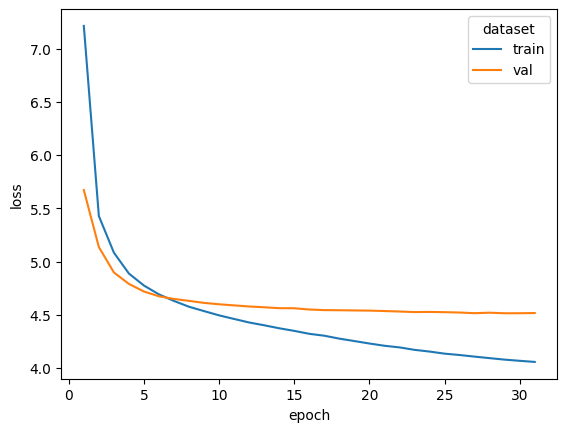

In [6]:
utils.plot_train_losses(train_losses, val_losses)

## Generate Text with Model

Start by loading a model and instantiating a tokenizer that can also map from tokens back to text. The `load_model` function will load the best performing model that has been persisted on the local filesystem.

In [7]:
best_model: tfr.NextWordPredictionTransformer = utils.load_model(MODEL_NAME)

loading .models/decoder_next_word_gen_with_bpe/trained@2023-07-17T21:55:44;loss=4_4922.pt


Then set a prompt.

In [8]:
prompt = "Now I love horror, but I found this"

### Greedy Decoding Strategy

Pass a prompt to the model and use a greedy decoding strategy to generate new text.Now pass a prompt to the model and get it to generate the text that comes after.

In [9]:
text = tfr.generate(best_model, prompt, datasets.tokenizer, "greedy", temperature=1.0)
print(text)

==> NOW I LOVE HORROR, BUT I FOUND THIS movie to be a good movie. I was very
disappointed. I was very disappointed. I was very disappointed. I was disappointed that
the movie was very good. I was very disappointed. I was very disappointed. I was
disappointed that the movie was made. I was very much better than the acting and...


### Top-k Decoding Strategy

Pass a prompt to the model and use a top-k decoding strategy to generate new text (with k=3).

In [10]:
text = tfr.generate(
    best_model, prompt, datasets.tokenizer, "topk", temperature=1.0, k=3
)
print(text)

==> NOW I LOVE HORROR, BUT I FOUND THIS movie to be very entertaining. I was very
disappointed. It was a great film, but it is a good movie and the acting is superb, and
the story was very good. I was very disappointed in this movie. The plot is very simple
and very good acting. It's direction and the plot...


### Sampling Decoding Strategy

Pass a prompt to the model and use a sampling decoding strategy to generate new text.

In [11]:
text = tfr.generate(best_model, prompt, datasets.tokenizer, "sample", temperature=1.0)
print(text)

==> NOW I LOVE HORROR, BUT I FOUND THIS one to be soo bad. Acting can have excellent
dialog, saving a time eternal search for sci fiore cost. The only problem was in the end,
it was too bad. Very bad movie. I was thoroughly disappointed in the first part and were
mildly predictable and unnecessary activities in my rating on...


### Benchmark

Compare all output with that from an untrained model.And compare this output with that from an untrained model.

In [12]:
untrained_model = tfr.NextWordPredictionTransformer(
    datasets.tokenizer.vocab_size, SIZE_EMBED
)
text = tfr.generate(
    untrained_model, prompt, datasets.tokenizer, temperature=1.0, device=DEVICE
)
print(text)

==> NOW I LOVE HORROR, BUT I FOUND THIS atomic atomic atomicish consumer atomic 99 99 99
Tak Tak copies copies copies copies atomic edits copies consumer copies copies copies
edits edits copies copies copies copies Tak Tak Tak Tak Tak Tak Tak Tak Tak Tak
Tak¨eitheriana low1990199019901990 firefighter firefighterbably autopsybablybably copies
copies copies copies copies copies copies...
